# Chapter 4 - Deep Learning Fundamentals



In [1]:
from datetime import datetime
from PIL import Image
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.transforms.functional import to_pil_image
from fastai.vision.all import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

torch.__version__
torch.tensor([1,2,3], device="mps")


tensor([1, 2, 3], device='mps:0')

The chapter requires using the mnist dataset which can be loaded from the fastai library.

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()


(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [3]:
(path / 'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [4]:
# load 3s 7s paths
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()


In [5]:
# load 3 image example
im3_path = threes[1]
im3 = Image.open(im3_path)
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
print(im3_t.shape)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


torch.Size([28, 28])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [6]:
# create train test sets
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
print(len(three_tensors),len(seven_tensors))


stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
print("stacked threes shape:", stacked_threes.shape)

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)


6131 6265
stacked threes shape: torch.Size([6131, 28, 28])


## Createing a learner class from scratch

One of the tasks from chapter 4 is to implement a deeplearning learner class from scratch in python. The learner class should use the following steps:
1. Initialize the weights.
1. For each image, use these weights to predict whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its loss).
1. Calculate the gradient, which measures for each weight, how changing that weight would change the loss
1. Step (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and repeat the process.
1. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).


In [7]:
# create datasets & data loaders
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

dset = list(zip(train_x,train_y))
x,y = dset[0]
print("x, y shape:", x.shape,y)

dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
print("xb, yb shape:", xb.shape,yb.shape)

valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

valid_dl = DataLoader(valid_dset, batch_size=256)
dl = DataLoader(dset, batch_size=256)

dls = DataLoaders(dl, valid_dl)


valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

valid_dl = DataLoader(valid_dset, batch_size=256)
print("valid batch x shape:", valid_dl.one_batch()[0].shape)
print("valid batch y shape:", valid_dl.one_batch()[1].shape)

x, y shape: torch.Size([784]) tensor([1])
xb, yb shape: torch.Size([256, 784]) torch.Size([256, 1])
valid batch x shape: torch.Size([256, 784])
valid batch y shape: torch.Size([256, 1])


In [8]:
class CustomLearner:
    def __init__(self, dls, model, opt_func, loss_func, metrics, lr):
        self.dls = dls
        self.model = model
        self.loss_func = loss_func
        self.metrics = metrics
        self.opt = opt_func(self.model.parameters(), lr)

    def calc_grad(self, xb, yb, model):
        self.preds = model(xb)
        self.train_loss = self.loss_func(self.preds, yb)
        self.train_loss.backward()

    def validate_epoch(self):
        self.model.eval()
        with torch.no_grad():
            losses = [self.loss_func(self.model(xb), yb) for xb,yb in self.dls.valid]
            metrics = [self.metrics(self.model(xb), yb) for xb,yb in self.dls.valid]
        
        self.valid_loss = torch.stack(losses).mean().item()
        self.valid_metric = torch.stack(metrics).mean().item()
        
        self.model.train()
        
        return self.valid_loss, self.valid_metric
    
    def train_epoch(self):
        self.model.train()
        self.batch_losses = []
        
        for xb,yb in self.dls.train:
            self.calc_grad(xb, yb, self.model)
            self.batch_losses.append(self.train_loss.item())  # Store each batch loss
            self.opt.step()
            self.opt.zero_grad()
        
        # Calculate average training loss for the epoch
        self.train_loss_epoch = sum(self.batch_losses) / len(self.batch_losses)

    def fit(self, epochs):
        results = []
        for i in range(epochs):
            start = datetime.now()
            self.train_epoch()
            self.validate_epoch()
            end = datetime.now()
            row = {
                "epoch":i,
                "train_loss":self.train_loss_epoch, 
                "valid_loss":self.valid_loss, 
                "accuracy":self.valid_metric, 
                "time": (end - start).total_seconds()

            }
            results.append(row)

        results_df = pd.DataFrame().from_records(results)
        return results_df
    
    def get_top_losses(self, n=5):
        # Set model to evaluation mode
        self.model.eval()
        
        # Lists to store losses and indices
        all_losses = []
        all_preds = []
        all_targets = []
        indices = []
        idx = 0
        
        # Loop through validation data
        with torch.no_grad():
            for xb, yb in self.dls.valid:
                # Flatten images if needed
                if xb.dim() > 2:
                    xb = xb.view(xb.size(0), -1)
                    
                # Get predictions
                preds = self.model(xb)
                
                # Calculate loss per item (don't take mean yet)
                if isinstance(self.loss_func, nn.CrossEntropyLoss):
                    # For cross entropy, need to calculate per item manually
                    losses = F.cross_entropy(preds, yb, reduction='none')
                else:
                    # For other losses, try to get per item loss
                    losses = self.loss_func(preds, yb, reduction='none') if hasattr(self.loss_func, 'reduction') else torch.tensor([0.0])
                
                # Store everything
                batch_indices = torch.arange(idx, idx + len(xb))
                indices.append(batch_indices)
                all_losses.append(losses)
                all_preds.append(preds)
                all_targets.append(yb)
                idx += len(xb)
        
        indices = torch.cat(indices).cpu()
        losses = torch.cat(all_losses).cpu()
        preds = torch.cat(all_preds).cpu()
        targets = torch.cat(all_targets).cpu()
        sorted_idx = losses.argsort(descending=True)
        
        return {
            'indices': indices[sorted_idx[:n]],
            'losses': losses[sorted_idx[:n]],
            'preds': preds[sorted_idx[:n]],
            'targets': targets[sorted_idx[:n]]
        }


class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

linear_model = nn.Linear(28*28,1)
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)
     
lr = 0.1
learn = CustomLearner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy,
                lr=lr)
learn.fit(10)




,epoch,train_loss,valid_loss,accuracy,time
0,0,0.298524,0.421147,0.506836,0.043448
1,1,0.103594,0.220982,0.813965,0.037394
2,2,0.054630,0.111273,0.917949,0.034627
3,3,0.042221,0.075479,0.944785,0.035354
4,4,0.036546,0.059221,0.959921,0.036113
5,5,0.033099,0.050126,0.963339,0.035703
6,6,0.030643,0.044393,0.966269,0.036614
7,7,0.028738,0.040462,0.966757,0.037873
8,8,0.027200,0.037586,0.969199,0.036476
9,9,0.025928,0.035371,0.970663,0.038588


# Classifying the full MNIST Dataset

Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.


In [9]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)


In [10]:

net = nn.Sequential(
    nn.Flatten(),  # This replaces the img.view(-1, 28*28) operation
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)


In [11]:
cross_el = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) #e-1
epoch = 10

for epoch in range(epoch):
    net.train()

    for data in train_loader:
        x, y = data
        optimizer.zero_grad()
        output = net(x.view(-1, 28*28))
        loss = cross_el(output, y)
        loss.backward()
        optimizer.step()


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        x, y = data
        output = net(x.view(-1, 784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct +=1
            total +=1
print(f'accuracy: {round(correct/total, 3)}')


accuracy: 0.965


In [13]:
# test different test casses

example_idx = 32
example, label = test_loader.dataset[example_idx]
# Add batch dimension and pass as input
with torch.no_grad():  # No need to track gradients for prediction
    output = net(example.unsqueeze(0))
    
# Get predicted class
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.item()  # Convert tensor to Python scalar

print("Predicted class:", predicted_class)
print("Actual class:", label)
pil_img = to_pil_image(example)
display(pil_img)

Predicted class: 3
Actual class: 3


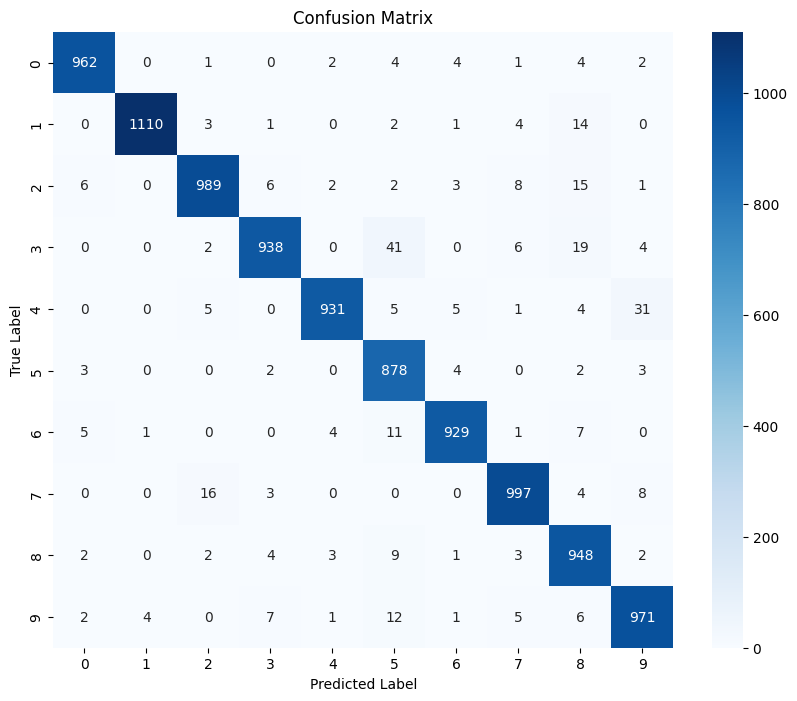

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       1.00      0.98      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.98      0.93      0.95      1010
           4       0.99      0.95      0.97       982
           5       0.91      0.98      0.95       892
           6       0.98      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.93      0.97      0.95       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.96     10000
weighted avg       0.97      0.97      0.97     10000



In [14]:
# create classifcation matrix
y_pred = []
y_true = []

net.eval() # stops layer behaviour messing up

with torch.no_grad(): # turns gradient tracking claculations off since doing inference only
    for data, target in test_loader:
        categroy_preds = net(data)
        _, predicted = torch.max(categroy_preds, 1) # get most likely category
        
        # Extend lists
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(target.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))